# Bernoulli bandit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class BernoulliBandit():

    # Creates a k-armed bandit with given probabilities of success
    def __init__(self, probabilities):
        self.probabilities = probabilities

    # 1 with probability p[n] and 0 with probability 1-p[n]
    def sample(self, n):
        return np.random.binomial(1, self.probabilities[n])

# Running the bandit



In [ ]:
# Setting up the bandit
d = 0.2
probabilities = [0.7, 0.7 - d, 0.7 - 2*d]
bandit = BernoulliBandit(probabilities)



# Run the bandit 100 times for each action
def get_samples(num_samples):
    return {str(round(p, 2)): [bandit.sample(n) for i in range(num_samples)] for n, p in enumerate(probabilities)}

# Get samples
samples = get_samples(100)

### Reward distribution by action

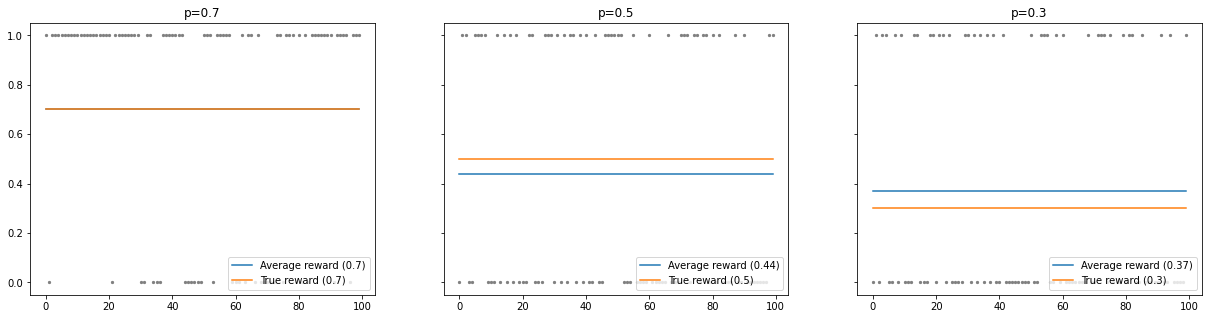

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 5), sharey=True)

for i, (p, sample) in enumerate(samples.items()):
    n = len(sample)
    mean = np.mean(sample)

    axs[i].scatter(range(n), sample, s=5, c='grey')
    axs[i].plot(range(n), [mean] * n, label=f'Average reward ({mean})')
    axs[i].plot(range(n), [float(p)] * n, label=f'True reward ({p})')

    axs[i].title.set_text(f'p={p}')
    axs[i].legend(loc='lower right')

# Monte Carlo evaluation

In [ ]:
# Calculates the estimated reward Qn+1 based on the previous estimate Qn, the previous reward Rn and the learning rate alpha
def update_avg(estimate, reward, alpha):
    return estimate + alpha * (reward - estimate)

# Calculates the estimated reward at each time step
def get_estimates(rewards, alpha=None):
    estimate = 0
    all_estimates = []

    for t, reward in enumerate(rewards):
        # [OPTIONAL] Use α
        if alpha is not None:
            estimate = update_avg(estimate, reward, alpha)
        else:
            estimate = update_avg(estimate, reward, 1/(t+1))

        # Add to list
        all_estimates.append(estimate)

    return all_estimates

### Results

In [ ]:
# We can play around with number of samples to observe convergence over different timescales
samples = get_samples(num_samples=100)

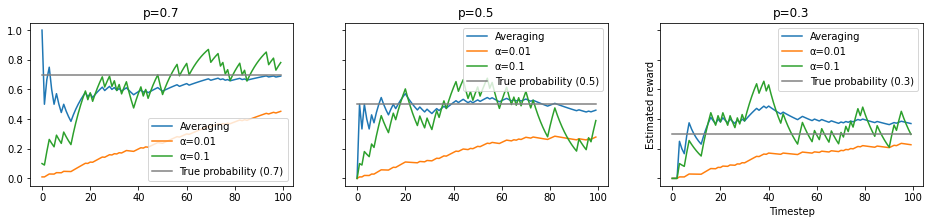

In [ ]:
# Plot settings
fig, axs = plt.subplots(1, 3, figsize=(16, 3), sharey=True)
plt.xlabel('Timestep')
plt.ylabel('Estimated reward')

# Plotting results
for i, (p, sample) in enumerate(samples.items()):
    n = len(sample)

    axs[i].plot(range(n), get_estimates(sample), label='Averaging')
    axs[i].plot(range(n), get_estimates(sample, alpha=0.01), label='α=0.01')
    axs[i].plot(range(n), get_estimates(sample, alpha=0.1), label='α=0.1')
    axs[i].plot(range(n), [float(p)] * n, label=f'True probability ({p})', c='grey')

    axs[i].title.set_text(f'p={p}')
    axs[i].legend(loc='best')

# Repeating the experiment

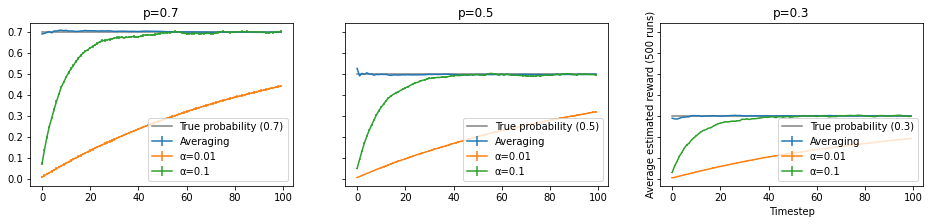

In [ ]:
# Plot settings
fig, axs = plt.subplots(1, 3, figsize=(16, 3), sharey=True)
plt.xlabel('Timestep')
plt.ylabel('Average estimated reward (500 runs)')

timesteps = 100
num_runs = 500

# Plotting results
for i in range(3):
    p = round(probabilities[i], 2)

    a1 = np.mean([get_estimates([bandit.sample(i) for t in range(timesteps)]) for r in range(num_runs)], axis=0)
    a2 = np.mean([get_estimates([bandit.sample(i) for t in range(timesteps)], alpha=0.01) for r in range(num_runs)], axis=0)
    a3 = np.mean([get_estimates([bandit.sample(i) for t in range(timesteps)], alpha=0.1) for r in range(num_runs)], axis=0)

    axs[i].errorbar(range(timesteps), a1, yerr=np.std(a1)/np.sqrt(num_runs), label='Averaging')
    axs[i].errorbar(range(timesteps), a2, yerr=np.std(a2)/np.sqrt(num_runs), label='α=0.01')
    axs[i].errorbar(range(timesteps), a3, yerr=np.std(a3)/np.sqrt(num_runs), label='α=0.1')
    axs[i].plot(range(timesteps), [p] * timesteps, label=f'True probability ({p})', c='grey')

    axs[i].title.set_text(f'p={p}')
    axs[i].legend(loc='lower right')

Using $\alpha = 0.1$ leads to must faster convergence as more weight is given to recent estimates. Similarly to gradient descent, a smaller learning rate implies steadier and more accurate estimates at the cost of slower convergence.

Following from the binomial distribution we implemented, averaging fits the true action probability best.

To further optimize, we chould choose $\alpha$ to be between 0.01 and 0.1 would ensure convergence while reducing the amount of noise.

# ϵ-greedy

In [ ]:
class Agent():

    # =====[ INITIALIZATION ]=====
    def __init__(self, bandit):
        self.bandit = bandit
        self.k_arms = len(self.bandit.probabilities)
        self.n_actions = np.zeros(self.k_arms)
        self.current_estimates = np.zeros(self.k_arms)
        self.estimates = []
        self.rewards = []


    # =====[ EPSILON-GREEDY ]=====
    def epsilon_greedy(self, epsilon):
        # Explore (probability ϵ)
        if np.random.random_sample() < epsilon:
            return np.random.choice(self.k_arms)

        # Exploit (probability 1-ϵ)
        else:
            highest_action = np.argmax(self.current_estimates)
            all_highest_actions = np.where(self.current_estimates == highest_action)[0]

            # If multiple actions have the same highest estimate, randomly choose one
            if len(all_highest_actions) == 0:
                return highest_action
            else:
                return np.random.choice(all_highest_actions)

     # =====[ SOFTMAX EXPLORATION ]=====
    def softmax_exploration(self, temperature):

        # All estimates divided by the temperature
        x = np.divide(self.current_estimates, temperature)
        e_x = np.exp(x - np.max(x))
        softmax_probabilities = e_x / e_x.sum(axis=0)

        return np.random.choice(self.k_arms, p=softmax_probabilities)


    # =====[ RUNNING THE AGENT ]=====
    def run(self, timesteps, epsilon, temperature, alpha, decay, non_stationary):

        # Reset the agent
        self.__init__(bandit)

        # Play at every timestep
        for t in range(timesteps):
            # [OPTIONAL] Decay ϵ
            if epsilon is not None and decay is not None:
                epsilon *= decay

            # [OPTIONAL] Non-stationary rewards
            if non_stationary and t == 500:
                d = 0.1
                probabilities = [0.7, 0.7 + d, 0.7 + 2*d]
                self.bandit = BernoulliBandit(probabilities)

            # [1] Choose action
            if temperature is not None:
                action = self.softmax_exploration(temperature)
            else:
                action = self.epsilon_greedy(epsilon)


            estimated_reward = self.current_estimates[action]
            self.n_actions[action] += 1

            # [2] Run the bandit
            actual_reward = self.bandit.sample(action)

            # [3] Update reward estimates
            # [OPTIONAL] Use α for recency-weighted averages
            if alpha is not None:
                self.current_estimates[action] = update_avg(estimated_reward, actual_reward, alpha)
            else:
                self.current_estimates[action] = update_avg(estimated_reward, actual_reward, 1/self.n_actions[action])

            # [OPTIONAL] Store reward and estimate for this timestep
            self.rewards.append(actual_reward)
            self.estimates.append(self.current_estimates.copy())


    # =====[ MULTIPLE RUNS ]=====
    def run_experiment(self, num_runs, timesteps, epsilon=None, temperature=None, alpha=None, decay=None, non_stationary=False):
        # Keep track of each run's state
        all_rewards = []
        all_estimates = []

        # For each run
        for i in range(num_runs):
            self.run(timesteps, epsilon, temperature, alpha, decay, non_stationary)
            all_rewards.append(self.rewards)
            all_estimates.append(self.estimates)

        return {'rewards': all_rewards, 'estimates': all_estimates}

### Results

In [ ]:
def analyze(bandit, num_runs, timesteps, epsilon_values, decay=None):

    # Get optimal ratio
    def get_optimal_ratio(r):
        counts = np.zeros(timesteps)

        for all_estimates in r['estimates']:
            for t, estimate in enumerate(all_estimates):
                if np.argmax(estimate) == 0:
                    counts[t] += 1

        return [count / num_runs for count in counts]

    # Experiment
    agent = Agent(bandit)
    results = {str(epsilon): agent.run_experiment(num_runs, timesteps, epsilon, decay=decay) for epsilon in epsilon_values}
    optimal_ratios = {str(epsilon): get_optimal_ratio(results[str(epsilon)]) for epsilon in epsilon_values}

    # Plot
    figure, subplots = plt.subplots(4, 1, figsize=(20, 20))

    for epsilon in epsilon_values:

        # Average rewards
        average_rewards = np.mean(results[str(epsilon)]['rewards'], axis=0)
        subplots[0].errorbar(range(timesteps), average_rewards, yerr=np.std(average_rewards)/np.sqrt(num_runs), label=f'ϵ = {epsilon}')
        subplots[0].set_xlabel('Timesteps')
        subplots[0].set_ylabel('Average reward')
        subplots[0].legend()


        # Optimal action ratio
        subplots[1].plot(range(timesteps), optimal_ratios[str(epsilon)], label=f'ϵ = {epsilon}')
        subplots[1].set_xlabel('Timesteps')
        subplots[1].set_ylabel('Ratio of optimal estimate')
        subplots[1].legend()

        # Instantaneous regret
        average_instantaneous_regret = np.subtract([0.7] * timesteps, average_rewards)
        subplots[2].plot(range(timesteps), average_instantaneous_regret, label=f'ϵ = {epsilon}')
        subplots[2].set_xlabel('Timesteps')
        subplots[2].set_ylabel('Instantaneous regret')
        subplots[2].legend()

        # Total regret
        subplots[3].plot(range(timesteps), np.cumsum(average_instantaneous_regret), label=f'ϵ = {epsilon}')
        subplots[3].set_xlabel('Timesteps')
        subplots[3].set_ylabel('Total regret')
        subplots[3].legend()

    plt.legend()
    plt.show()

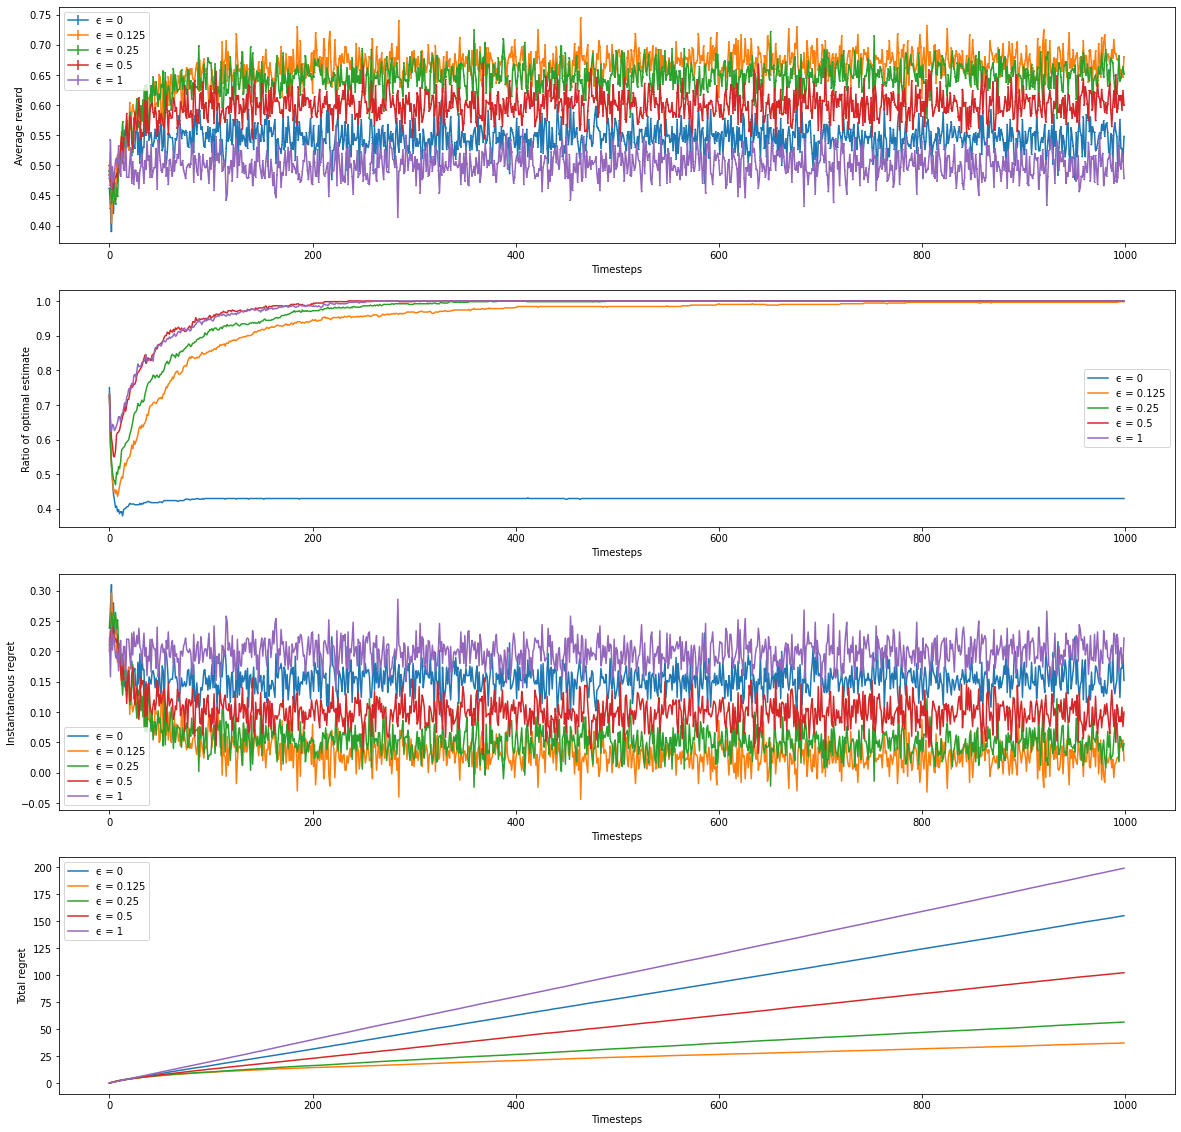

In [ ]:
# Bandit
d = 0.2
probabilities = [0.7, 0.7 - d, 0.7 - 2*d]
bandit = BernoulliBandit(probabilities)

# Experiment
analyze(bandit, num_runs=500, timesteps=1000, epsilon_values=[0, 1/8, 1/4, 1/2, 1])

Choosing to constantly explore ($\epsilon = 1$) yields the worst performance as it is equivalent to randomly selecting an action.

Choosing to constantly exploit ($\epsilon = 0$) is slightly better although it has inferior performance compared to smaller values of $\epsilon$.

In this experiment $\epsilon = \frac{1}{8}$ is the best value to choose.

# Changing the reward distribution

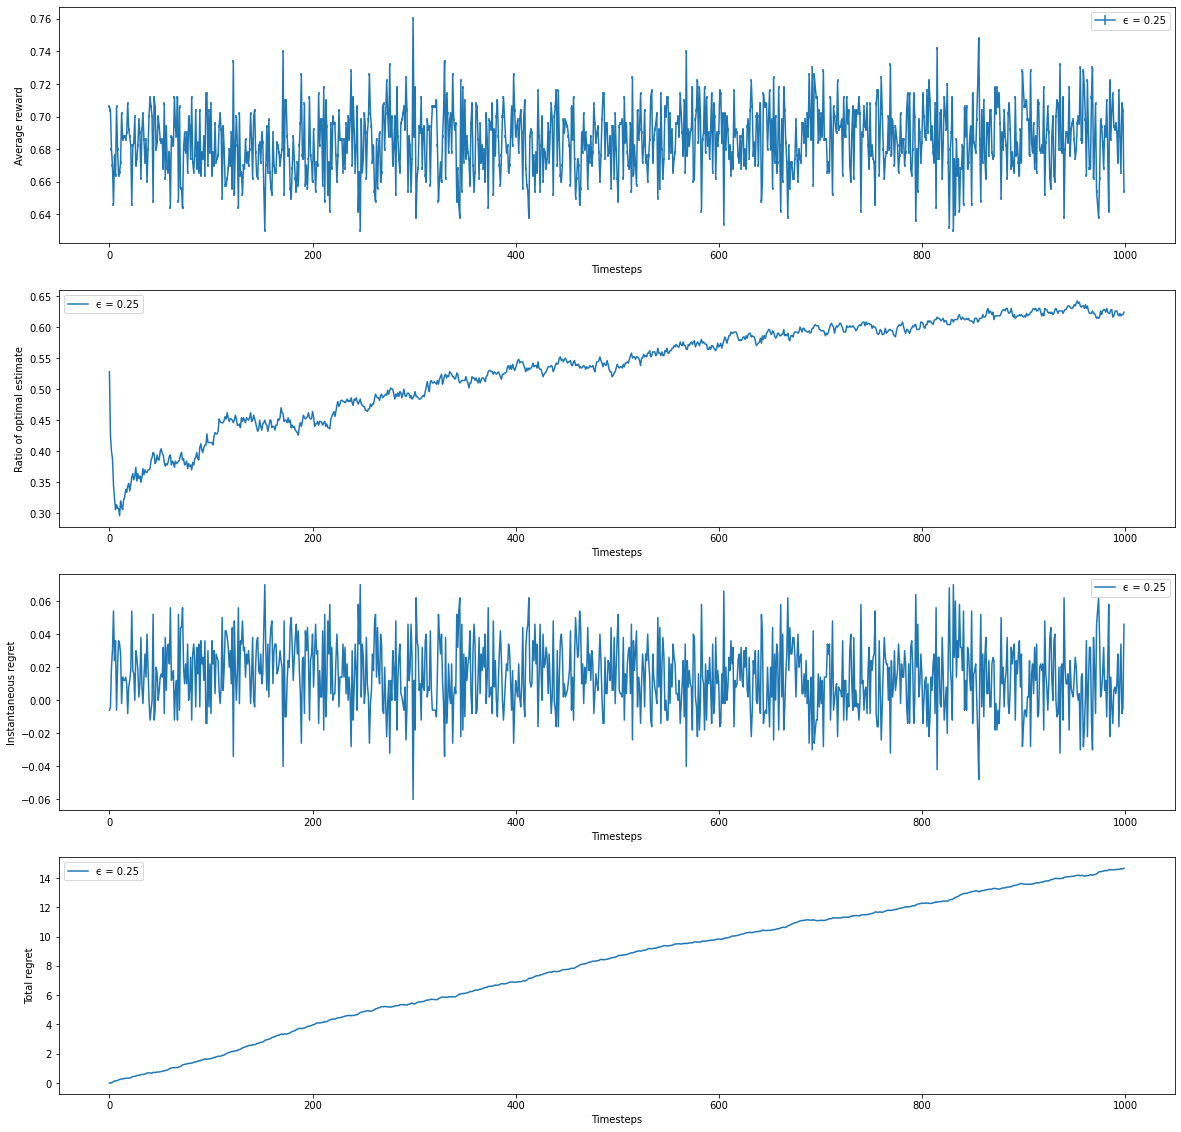

In [ ]:
# Bandit
d = 0.02
probabilities = [0.7, 0.7 - d, 0.7 - 2*d]
bandit = BernoulliBandit(probabilities)

# Experiment
analyze(bandit, num_runs=500, timesteps=1000, epsilon_values=[1/4])

After convergence, the agent values the optimal action highest about 60% of the time. In the previous experiment, a sufficient amount of updates nearly guaranteed that the highest-valued action would be the optimal one. This is not the case here.

If action-values diverge very little, any action can be selected without a significant difference in actual reward. There is less incentive to give up slightly suboptimal actions as their payoffs don't differ much and still provide a consequent reward.

# Decaying $\epsilon$

In [ ]:
# Bandit
d = 0.2
probabilities = [0.7, 0.7 - d, 0.7 - 2*d]
bandit = BernoulliBandit(probabilities)

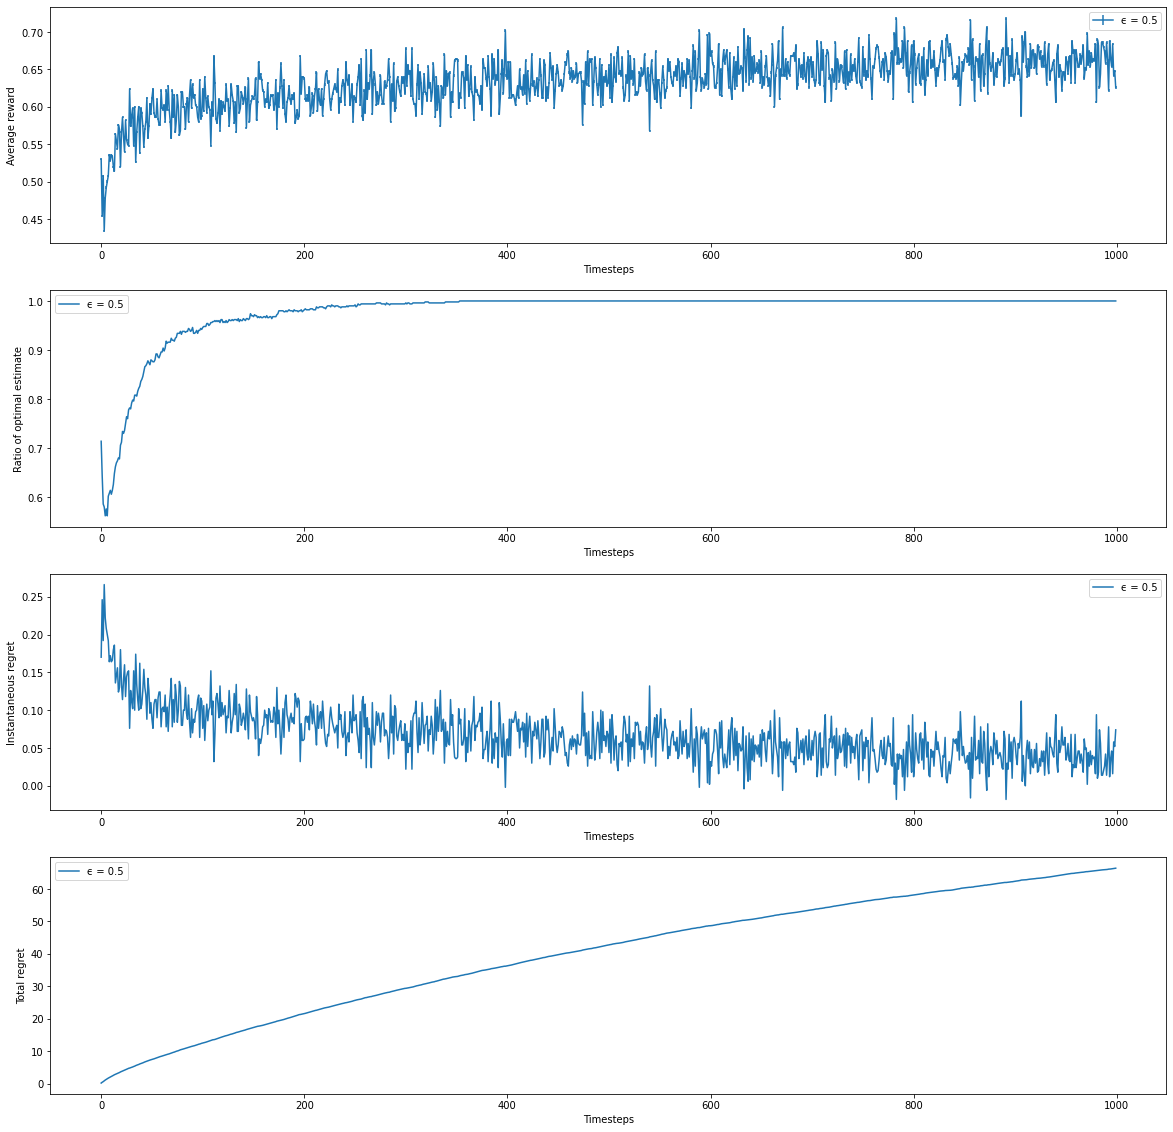

In [ ]:
# Using λ = 0.999
analyze(bandit, num_runs=500, timesteps=1000, epsilon_values=[1/2], decay=0.999)

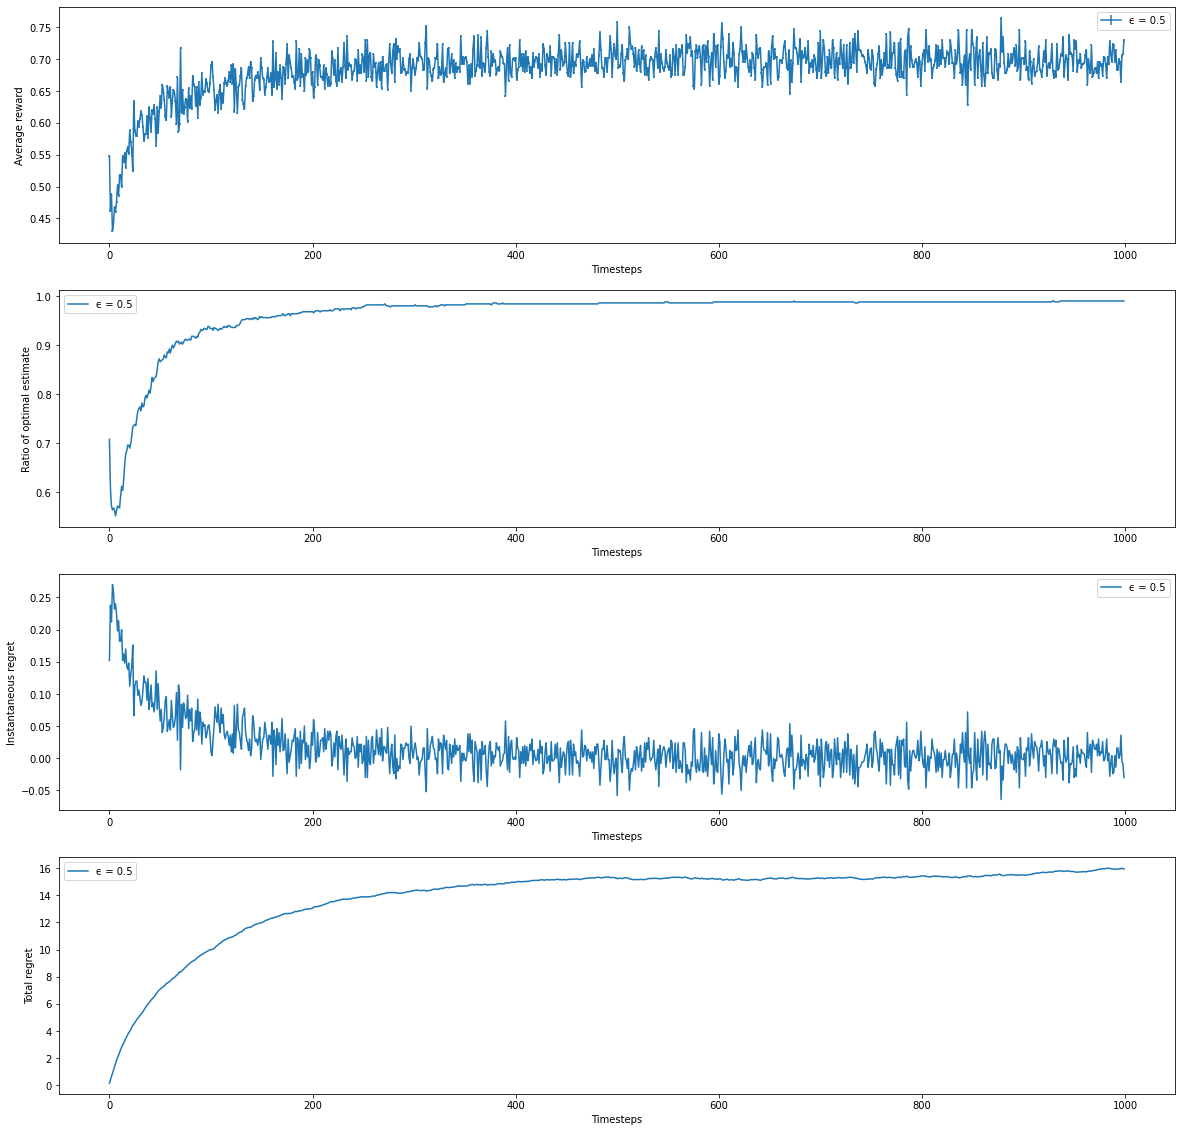

In [ ]:
# Using λ = 0.99
analyze(bandit, num_runs=500, timesteps=1000, epsilon_values=[1/2], decay=0.99)

Decaying $\epsilon$ over time allows the agent to avoid unnecessary exploration after good estimates have made.

In both cases, using a decay rate $\lambda$ seems to improve performance and lead to faster convergence over a fixed $\epsilon$.

A stronger decay rate of $\lambda = 0.99$ led to a remarkable total regret of $L_t \approx 17$, superior to the $L_t \approx 70$ by $\lambda = 0.999$.



# Non-stationary problem

In [ ]:
def test_parameters(num_runs, timesteps, epsilon, alpha, decay):
    # Bandit
    d = 0.1
    probabilities = [0.7, 0.7 - d, 0.7 - 2*d]
    bandit = BernoulliBandit(probabilities)

    # Experiment
    experiment = {'alpha': {}, 'no_alpha': {}}

    experiment['no_alpha']['no_decay'] = Agent(bandit).run_experiment(num_runs, timesteps, epsilon=epsilon, alpha=None, decay=None, non_stationary=True)
    experiment['no_alpha']['decay'] = Agent(bandit).run_experiment(num_runs, timesteps, epsilon=epsilon, alpha=None, decay=decay, non_stationary=True)
    experiment['alpha']['no_decay'] = Agent(bandit).run_experiment(num_runs, timesteps, epsilon=epsilon, alpha=alpha, decay=None, non_stationary=True)
    experiment['alpha']['decay'] = Agent(bandit).run_experiment(num_runs, timesteps, epsilon=epsilon, alpha=alpha, decay=decay, non_stationary=True)

    # Plotting
    plt.figure(figsize=(21,5))
    plt.title(f'Testing parameters with ϵ = {epsilon}')
    plt.xlabel('Timesteps')
    plt.ylabel('Average reward')

    e1 = np.mean(experiment['no_alpha']['no_decay']['rewards'], axis=0)
    e2 = np.mean(experiment['no_alpha']['decay']['rewards'], axis=0)
    e3 = np.mean(experiment['alpha']['no_decay']['rewards'], axis=0)
    e4 = np.mean(experiment['alpha']['decay']['rewards'], axis=0)

    plt.errorbar(range(timesteps), e1, lw=1, yerr=np.std(e1)/np.sqrt(num_runs), label='Averaging | Fixed ϵ')
    plt.errorbar(range(timesteps), e2, lw=1, yerr=np.std(e2)/np.sqrt(num_runs), label=f'Averaging | λ = {decay}')
    plt.errorbar(range(timesteps), e3, lw=1, yerr=np.std(e3)/np.sqrt(num_runs), label=f'α = {alpha} | Fixed ϵ')
    plt.errorbar(range(timesteps), e4, lw=1, yerr=np.std(e4)/np.sqrt(num_runs), label=f'α = {alpha} | λ = {decay}')

    plt.legend()
    plt.show()

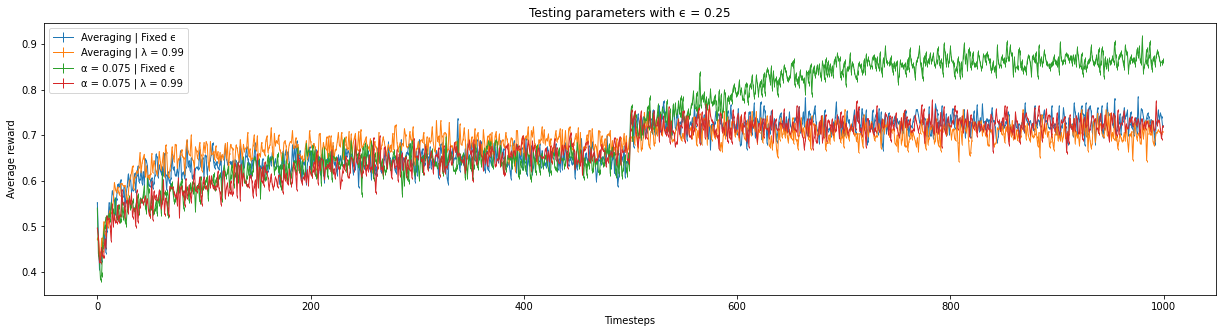

In [ ]:
# Run experiment
test_parameters(num_runs=500, timesteps=1000, epsilon=1/4, alpha=0.075, decay=0.99)

Performance seems to be roughly equivalent among agents while rewards are stable. Modifying the rewards at $t = 500$ leads clearer differenciation.

Using a decay rate seems to harm performance, with both agents using $\lambda = 0.99$ achieving worse performance than agents with fixed $\epsilon$.
Since over time the agents are less likely to explore, they won't gravitate towards the new and better rewards as they stick to the previous optimal estimate.

The agent with fixed $\epsilon$ and $\alpha = 0.075$ outperforms the others. Using recency-weighted estimates is especially adapted to this kind of non-stationary problem as it allows the agent to be more reactive to changes in its environmment.

# Boltzmann exploration

In [ ]:
# Bandit
d = 0.2
probabilities = [0.7, 0.7 - d, 0.7 - 2*d]
bandit = BernoulliBandit(probabilities)

# Experiment
temperatures = [1000, 10, 1, 0.1]
num_runs = 50
timesteps= 1000

# Results
average_rewards = {str(T): np.mean(Agent(bandit).run_experiment(num_runs, timesteps, temperature=T, non_stationary=True)['rewards'], axis=0) for T in temperatures}

### Results

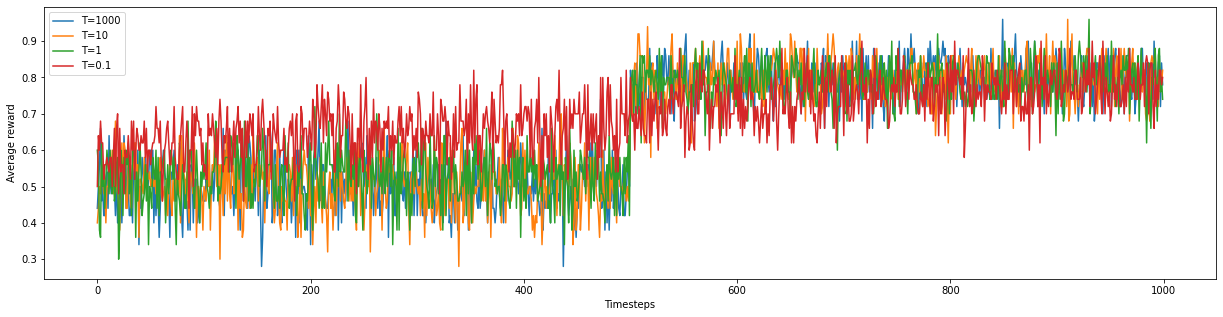

In [ ]:
plt.figure(figsize=(21,5))
plt.xlabel('Timesteps')
plt.ylabel('Average reward')

for T in temperatures:
    plt.plot(range(timesteps), average_rewards[str(T)], label=f'T={T}')

plt.legend()
plt.show()

The agent with the lowest temperature $T = 0.1$ outperforms all others. Their respective performances seem to decrease as $T$ increases, although logarithmically higher temperatures only incur a slight drop in performance.

Both $\epsilon$-greedy and Boltzmann exploration achieve similar performance given proper parameters. They both remain roughly constant through time.
However, Boltzmann exploration seems to converge faster at the cost of a noisier reward distribution.